In [164]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy import interpolate

## Least Squares Method

In [126]:
f = h5py.File('C:\\Users\josep\Downloads\data_psi_zero.hdf5', 'r')

In [127]:
list(f.keys())

['DSV_00', 'U', 'Uk', 'eta', 'k', 't', 'x', 'y', 'z']

In [128]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')

In [129]:
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)

In [130]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Downloads\data_psi_zero.hdf5")

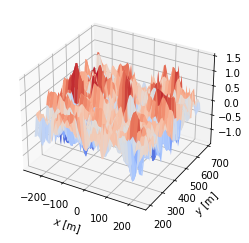

In [7]:
surf3d.plot_3d_surface()
plt.show()

In [8]:
spec3d = surf3d.define_SpectralAnalysis()
spec3d

In [9]:
spec3d.spectrum().shape

(1200, 66, 66)

In [10]:
spec3d.w[len(t)//2:]

array([-4.44089210e-16,  5.23598776e-03,  1.04719755e-02,  1.57079633e-02,
        2.09439510e-02,  2.61799388e-02,  3.14159265e-02,  3.66519143e-02,
        4.18879020e-02,  4.71238898e-02,  5.23598776e-02,  5.75958653e-02,
        6.28318531e-02,  6.80678408e-02,  7.33038286e-02,  7.85398163e-02,
        8.37758041e-02,  8.90117919e-02,  9.42477796e-02,  9.94837674e-02,
        1.04719755e-01,  1.09955743e-01,  1.15191731e-01,  1.20427718e-01,
        1.25663706e-01,  1.30899694e-01,  1.36135682e-01,  1.41371669e-01,
        1.46607657e-01,  1.51843645e-01,  1.57079633e-01,  1.62315620e-01,
        1.67551608e-01,  1.72787596e-01,  1.78023584e-01,  1.83259571e-01,
        1.88495559e-01,  1.93731547e-01,  1.98967535e-01,  2.04203522e-01,
        2.09439510e-01,  2.14675498e-01,  2.19911486e-01,  2.25147474e-01,
        2.30383461e-01,  2.35619449e-01,  2.40855437e-01,  2.46091425e-01,
        2.51327412e-01,  2.56563400e-01,  2.61799388e-01,  2.67035376e-01,
        2.72271363e-01,  

In [11]:
np.abs(spec3d.w)

array([3.14159265, 3.13635667, 3.13112068, ..., 3.12588469, 3.13112068,
       3.13635667])

In [12]:
freqs = np.arange(1, 2, 0.1)
kx_list = []
ky_list = []

for f in freqs:
    i = np.argmin(np.abs(spec3d.w[len(t)//2:] - f))
    # Finds the index of the closest value in spec3d.w to f 
        
    spec = spec3d.spectrum()
    spec_values = spec[len(t)//2 + i,:,:]
    # Gives the kx and ky values of corresponding to the frequencie[i]
    
    max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
    # Finds the specific index of the maximum value in spec_values
    
    max_kx = spec3d.kx[max_index[0]]
    max_ky = spec3d.ky[max_index[1]]
    # Finds the value of kx and ky corresponding to the maximum spectral density 
        
    kx_list.append(max_kx)
    ky_list.append(max_ky)
    

In [13]:
def plot_triplets_vs_disp_surface(thresh_freq, max_freq, step_size, h, z, U, psi):
    freqs = np.arange(thresh_freq, max_freq, step_size)
    kx_list = []
    ky_list = []

    for f in freqs:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:] - f))
        # Finds the index of the closest value in spec3d.w to f 
        
        spec = spec3d.spectrum()
        spec_values = spec[len(t)//2 + i,:,:]
        # Gives the kx and ky values of corresponding to the frequencie[i]
    
        max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
        # Finds the specific index of the maximum value in spec_values
    
        max_kx = spec3d.kx[max_index[0]]
        max_ky = spec3d.ky[max_index[1]]
        # Finds the value of kx and ky corresponding to the maximum spectral density 
        
        kx_list.append(max_kx)
        ky_list.append(max_ky)
    
    fig = plt.figure(figsize=(7,7))
    axes = fig.add_subplot(111, projection='3d')
    plotting_interface.plot_disp_shell(axes, h, z, U, psi)
    
    kx = np.array(kx_list)
    ky = np.array(ky_list)    

    for j in range(0, len(freqs)):
        axes.scatter(kx_list[j], ky_list[j], freqs[j], color='red', s=40)
    
    plt.show()
    
    return kx, ky, freqs

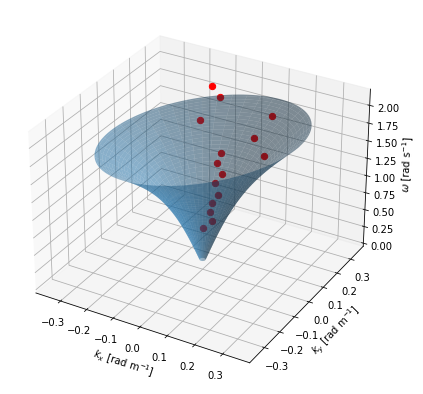

In [14]:
kx, ky, freqs = plot_triplets_vs_disp_surface(thresh_freq = 0.5 , max_freq = 2, step_size = 0.1, h = 10, z=z, U=U , psi = 0)

In [15]:
k_trip = np.sqrt( kx**2 + ky**2)
# Triplets k_i values

In [16]:
kx

array([-0.0126933 ,  0.0126933 ,  0.        ,  0.        ,  0.0126933 ,
       -0.0126933 ,  0.        , -0.02538661, -0.02538661,  0.12693304,
        0.06346652, -0.12693304,  0.08885313, -0.10154643, -0.13962634])

In [17]:
k

array([0.01  , 0.0105, 0.011 , 0.0115, 0.012 , 0.0125, 0.013 , 0.0135,
       0.014 , 0.0145, 0.015 , 0.0155, 0.016 , 0.0165, 0.017 , 0.0175,
       0.018 , 0.0185, 0.019 , 0.0195, 0.02  , 0.0205, 0.021 , 0.0215,
       0.022 , 0.0225, 0.023 , 0.0235, 0.024 , 0.0245, 0.025 , 0.0255,
       0.026 , 0.0265, 0.027 , 0.0275, 0.028 , 0.0285, 0.029 , 0.0295,
       0.03  , 0.0305, 0.031 , 0.0315, 0.032 , 0.0325, 0.033 , 0.0335,
       0.034 , 0.0345, 0.035 , 0.0355, 0.036 , 0.0365, 0.037 , 0.0375,
       0.038 , 0.0385, 0.039 , 0.0395, 0.04  , 0.0405, 0.041 , 0.0415,
       0.042 , 0.0425, 0.043 , 0.0435, 0.044 , 0.0445, 0.045 , 0.0455,
       0.046 , 0.0465, 0.047 , 0.0475, 0.048 , 0.0485, 0.049 , 0.0495,
       0.05  , 0.0505, 0.051 , 0.0515, 0.052 , 0.0525, 0.053 , 0.0535,
       0.054 , 0.0545, 0.055 , 0.0555, 0.056 , 0.0565, 0.057 , 0.0575,
       0.058 , 0.0585, 0.059 , 0.0595, 0.06  , 0.0605, 0.061 , 0.0615,
       0.062 , 0.0625, 0.063 , 0.0635, 0.064 , 0.0645, 0.065 , 0.0655,
      

In [18]:
def w0(x):
    return np.sqrt(9.81 * x)

In [19]:
w0(k)

array([0.3132092 , 0.32094392, 0.32849658, 0.33587944, 0.34310348,
       0.35017853, 0.35711343, 0.3639162 , 0.37059412, 0.37715381,
       0.38360136, 0.3899423 , 0.39618178, 0.4023245 , 0.40837483,
       0.41433682, 0.42021423, 0.42601056, 0.43172908, 0.43737284,
       0.44294469, 0.44844732, 0.45388324, 0.45925483, 0.46456431,
       0.46981379, 0.47500526, 0.4801406 , 0.4852216 , 0.49024994,
       0.49522722, 0.50015498, 0.50503465, 0.50986763, 0.51465522,
       0.51939869, 0.52409923, 0.52875798, 0.53337604, 0.53795446,
       0.54249424, 0.54699634, 0.55146169, 0.55589118, 0.56028564,
       0.56464591, 0.56897276, 0.57326695, 0.57752922, 0.58176026,
       0.58596075, 0.59013134, 0.59427266, 0.59838533, 0.60246992,
       0.606527  , 0.61055712, 0.61456082, 0.6185386 , 0.62249096,
       0.62641839, 0.63032135, 0.63420028, 0.63805564, 0.64188784,
       0.6456973 , 0.64948441, 0.65324957, 0.65699315, 0.66071552,
       0.66441704, 0.66809805, 0.67175889, 0.67539988, 0.67902

Text(0.5, 1.0, 'k against $\\omega_{0}$')

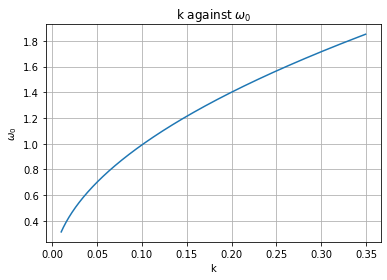

In [20]:
plt.plot(k,w0(k))

plt.xlabel("k")
plt.ylabel("$\omega_{0}$")
plt.grid(True)
plt.title("k against $\omega_{0}$")

In [21]:
# error function 
def error_function(U, k_trip, wi, w0):
    residuals = wi - w0 - k_trip*U
    return np.sum(residuals**2)

In [22]:
initial_U_guess = np.zeros(len(k_trip))

In [23]:
len(initial_U_guess)

15

In [24]:
len(k_trip)

15

In [25]:
result = minimize(error_function, initial_U_guess, args=(k_trip, freqs ,w0(k_trip)))

optimized_U = result.x
optimized_U

array([-0.97498328, -0.6853768 , -0.11361439,  0.17227115,  0.38462482,
       -0.01893918, -0.12520383,  0.14155546,  0.12114918, -0.29157779,
       -0.10630912,  0.28060519, -0.20286749,  0.18975156,  0.25920837])

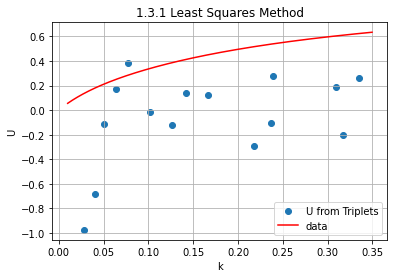

In [26]:
plt.scatter(k_trip, optimized_U, label = "U from Triplets")
plt.plot(k,Uk[:,0], label = 'data', color = 'red')

plt.xlabel("k")
plt.ylabel("U")
plt.grid(True)
plt.title("1.3.1 Least Squares Method")
plt.legend(loc = "lower right")

In [27]:
sorted(np.abs(optimized_U))

[0.018939184615243354,
 0.10630911757890109,
 0.11361439390060805,
 0.12114917675542405,
 0.12520383083848152,
 0.1415554606528148,
 0.17227115472065482,
 0.18975155542423938,
 0.20286748726426204,
 0.25920837198158314,
 0.28060519053981003,
 0.2915777870593781,
 0.3846248224043907,
 0.685376797536805,
 0.9749832849456788]

In [28]:
freqs - w0(k_trip) - k_trip*optimized_U

array([ 6.86064382e-07, -8.61793923e-07,  1.70286782e-05,  1.23410360e-05,
       -3.60262567e-06, -2.13501612e-05,  1.33921190e-06, -1.55887771e-07,
       -6.21161094e-07,  5.06114850e-07,  4.22067925e-06,  3.43730338e-08,
       -2.38289495e-06, -3.73034653e-07,  1.40124268e-06])

In [29]:
initial_U_guess

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [30]:
spec3d.spectrum().shape

(1200, 66, 66)

In [31]:
spec3d.estimate_Ueff_psi(h=10, Umax=2)

C:\Users\josep\Documents\Anaconda\pkgs\wave_tools\SpectralAnalysis.py:702: RuntimeWarning: invalid value encountered in divide
  w_peaks = (np.sum(input_spec**pow * ww**pow2, axis=0)/np.sum(input_spec**pow, axis=0))**(1./pow2)


(array([0.80110613, 0.80634211, 0.8115781 , 0.81681409, 0.82205008,
        0.82728607, 0.83252205, 0.83775804, 0.84299403, 0.84823002,
        0.853466  , 0.85870199, 0.86393798, 0.86917397, 0.87440996,
        0.87964594, 0.88488193, 0.89011792, 0.89535391, 0.90058989,
        0.90582588, 0.91106187, 0.91629786, 0.92153385, 0.92676983,
        0.93200582, 0.93724181, 0.9424778 , 0.94771378, 0.95294977,
        0.95818576, 0.96342175, 0.96865773, 0.97389372, 0.97912971,
        0.9843657 , 0.98960169, 0.99483767, 1.00007366, 1.00530965,
        1.01054564, 1.01578162, 1.02101761, 1.0262536 , 1.03148959,
        1.03672558, 1.04196156, 1.04719755, 1.05243354, 1.05766953,
        1.06290551, 1.0681415 , 1.07337749, 1.07861348, 1.08384947,
        1.08908545, 1.09432144, 1.09955743, 1.10479342, 1.1100294 ,
        1.11526539, 1.12050138, 1.12573737, 1.13097336, 1.13620934,
        1.14144533, 1.14668132, 1.15191731, 1.15715329, 1.16238928,
        1.16762527, 1.17286126, 1.17809725, 1.18

In [32]:
r = np.sqrt( (kx)**2 + (ky)**2 )
theta = np.arctan2(ky,kx)

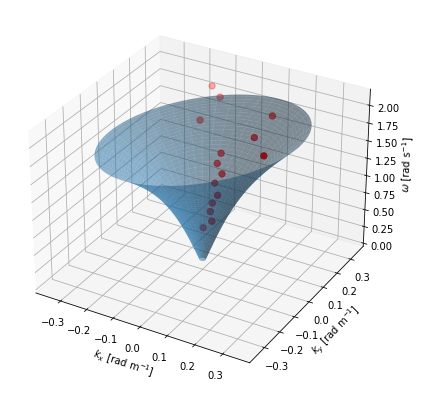

In [33]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')

plotting_interface.plot_disp_shell(axes, h=10, z = z, U = U, psi = 0)
axes.scatter(r*np.cos(theta), r*np.sin(theta), freqs, color='red', s=40)

In [34]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww

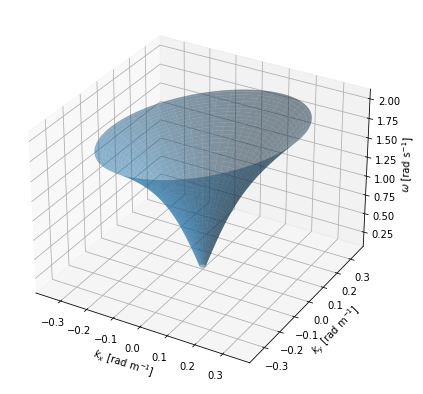

In [35]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h=10, z = z, U = U, psi = 0)

In [36]:
disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h, z, U, psi = 0)

NameError: name 'h' is not defined

In [37]:
def plot_disp_relation_and_points_at_theta(spec_theta, thresh_freq, max_freq, step_size, h, z, U, psi):
    '''
    This function finds the relationship between triplets found from spectrum from FFT 
    and the dispersion relation at specific theta. 
    It plots it in the Radial vs Omega Space. 
    '''
    
    # (1) TRIPLET POINTS
    
    freqs = np.arange(thresh_freq, max_freq, step_size)
    kx_list = []
    ky_list = []

    # This gets the triplets points 
    # Triplets are (max_kx, mak_ky, freqs)
    for f in freqs:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:]-f))
        spec = spec3d.spectrum()
        spec_values = spec[len(t)//2 + i,:,:]
        # Gives the spectrum values represented by colour
    
        max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
        # Finds the specific index of the maximum value in spec_values
    
        max_kx = spec3d.kx[max_index[0]]
        max_ky = spec3d.ky[max_index[1]]
        # Finds the value of kx and ky corresponding to the maximum spectral density 
        
        kx_list.append(max_kx)
        ky_list.append(max_ky)
        
    kx = np.array(kx_list)
    ky = np.array(ky_list)
    
    # transform Triplets to polar coordinates
    r = np.sqrt( (kx)**2 + (ky)**2 )
    theta = np.arctan2(ky,kx)
    
    # (2) DISPERSION SURFACE
    axes = fig.add_subplot(111, projection='3d')
    
    
    # Convert Dispersion Surface to Polars by first removing mesh grid format
    matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )
    disp_r = matrix_disp_r[:,0]
    
    matrix_disp_theta = np.arctan2(disp_ky,disp_kx)
    disp_theta = matrix_disp_theta[0]
    
    nearest_index = np.argmin(np.abs(disp_theta - spec_theta))
    disp_ww_for_theta = disp_ww[:, nearest_index]
    
    plt.scatter(r, freqs, color = 'red', zorder=1, label = 'Triplets', s = 40)
    plt.plot(disp_r,disp_ww_for_theta, color='grey',zorder=0, label = 'Dispersion Relation at $\Theta$')
    plt.grid(True)
    plt.xlabel('Radial Distance (r)')
    plt.ylabel('$\omega$')
    plt.title("Dispersion Relation vs Triplets in Radial-Frequency Space")
    plt.legend()
    
    return r, theta, freqs, kx, ky, disp_r, disp_ww_for_theta

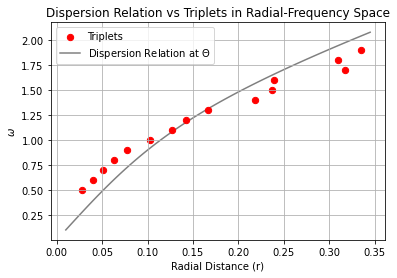

In [38]:
r, theta, freqs, kx, ky, disp_r,disp_ww_for_theta = plot_disp_relation_and_points_at_theta(0, thresh_freq = 0.5 , 
                                                  max_freq = 2, step_size = 0.1, h=10, 
                                                  z = z, U = U , psi = 0)

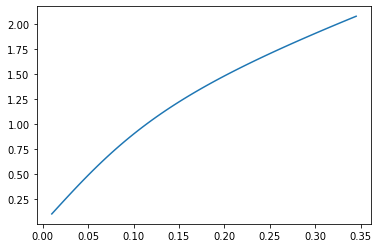

In [39]:
plt.plot(disp_r,disp_ww_for_theta)

# Try with actual values

In [40]:
DWL_kx = np.arange(0.01, 0.35, 0.0001)
DWL_ky = np.arange(0.01, 0.35, 0.0001)
# DWL = deep water limit

DWL_omega = np.sqrt( 9.81 * np.sqrt( (DWL_kx)**2  + (DWL_ky)**2 ) )
# DWL formula

In [41]:
# Find the value of DWL dispersion relation omega where the r values are closest to the DWL_kx values
near_indice = [np.argmin(np.abs(DWL_kx - rx)) for rx in r]

# Corresponding DWL_kx values
DWL_kx_values = DWL_kx[near_indice]
DWL_omega_values = DWL_omega[near_indice]

DWL_kx_values

array([0.0284, 0.0401, 0.0508, 0.0635, 0.0772, 0.1023, 0.1269, 0.1419,
       0.167 , 0.2184, 0.2371, 0.2395, 0.3173, 0.3091, 0.3351])

In [42]:
near_indice

[184,
 301,
 408,
 535,
 672,
 923,
 1169,
 1319,
 1570,
 2084,
 2271,
 2295,
 3073,
 2991,
 3251]

In [43]:
r

array([0.02838309, 0.04013975, 0.05077321, 0.06346652, 0.07721035,
       0.10233669, 0.12693304, 0.14191545, 0.16695434, 0.21838385,
       0.23713048, 0.23949677, 0.31733259, 0.30910214, 0.33511283])

In [44]:
disp_r

array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225, 0.23 ,
       0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 , 0.275,
       0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315, 0.32 ,
       0.325, 0.33 , 0.335, 0.34 , 0.345])

In [45]:
yoke = np.array([disp_ww_for_theta[4], disp_ww_for_theta[6], disp_ww_for_theta[9], disp_ww_for_theta[11],
                disp_ww_for_theta[13], disp_ww_for_theta[18], disp_ww_for_theta[23], disp_ww_for_theta[26],
                disp_ww_for_theta[31], disp_ww_for_theta[41], disp_ww_for_theta[45], disp_ww_for_theta[46],
                disp_ww_for_theta[62], disp_ww_for_theta[60], disp_ww_for_theta[65] ])

In [46]:
len(yoke)

15

In [47]:
# Objective function to be minimize
def objective(U,k_trip, DWL_omega_values, freqs):
    return DWL_omega_values - yoke + r*U*np.cos(0)

# Initial guess for U
initial_U = np.zeros(len(r))

# Perform the least squares fit using least_squares
result = least_squares(objective, initial_U, args=(k_trip, DWL_omega_values, disp_ww_for_theta))

# Optimized U values
optimized_U = result.x

# Print the optimized U values
print("Optimized U values:", optimized_U)

Optimized U values: [-11.6420229   -8.77646463  -6.04287736  -5.00260759  -4.2638314
  -2.84657816  -2.01426066  -1.68332811  -1.29484771  -0.85949037
  -0.72270382  -0.66319627  -0.35004572  -0.39544462  -0.3349357 ]


In [48]:
disp_ww_for_theta

array([0.09945258, 0.14925219, 0.19890704, 0.24828436, 0.29726204,
       0.34572921, 0.3935867 , 0.44074734, 0.48713606, 0.5326898 ,
       0.57735722, 0.62109827, 0.66388353, 0.70569348, 0.74651766,
       0.78635382, 0.8252069 , 0.86308821, 0.90001443, 0.93600679,
       0.97109023, 1.00529266, 1.03864424, 1.07117679, 1.10292323,
       1.13391711, 1.16419221, 1.19378216, 1.2227202 , 1.2510389 ,
       1.27877001, 1.30594427, 1.33259134, 1.35873971, 1.38441663,
       1.40964808, 1.43445879, 1.45887221, 1.48291052, 1.50659472,
       1.52994456, 1.5529787 , 1.57571463, 1.59816883, 1.62035674,
       1.64229285, 1.66399073, 1.6854631 , 1.70672185, 1.72777813,
       1.74864236, 1.76932427, 1.78983298, 1.81017702, 1.83036435,
       1.85040243, 1.87029824, 1.8900583 , 1.90968872, 1.92919523,
       1.94858319, 1.96785761, 1.98702321, 2.00608442, 2.02504537,
       2.04390997, 2.06268188, 2.08136456])

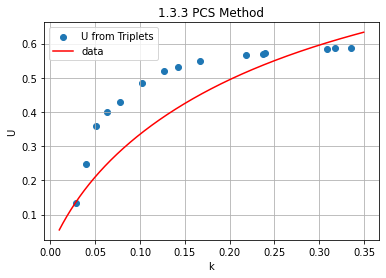

In [49]:
plt.scatter(k_trip, 0.04*optimized_U + 0.6, label = "U from Triplets")
plt.plot(k,Uk[:,0], label = "data", color = "red")

plt.xlabel("k")
plt.ylabel("U")
plt.title("1.3.3 PCS Method")
plt.grid(True)
plt.legend()

## Test Method

In [228]:
f = h5py.File('C:\\Users\josep\Downloads\data_psi_zero.hdf5', 'r')

In [229]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')

In [230]:
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)

In [231]:
kx

array([0.01  , 0.0105, 0.011 , 0.0115, 0.012 , 0.0125, 0.013 , 0.0135,
       0.014 , 0.0145, 0.015 , 0.0155, 0.016 , 0.0165, 0.017 , 0.0175,
       0.018 , 0.0185, 0.019 , 0.0195, 0.02  , 0.0205, 0.021 , 0.0215,
       0.022 , 0.0225, 0.023 , 0.0235, 0.024 , 0.0245, 0.025 , 0.0255,
       0.026 , 0.0265, 0.027 , 0.0275, 0.028 , 0.0285, 0.029 , 0.0295,
       0.03  , 0.0305, 0.031 , 0.0315, 0.032 , 0.0325, 0.033 , 0.0335,
       0.034 , 0.0345, 0.035 , 0.0355, 0.036 , 0.0365, 0.037 , 0.0375,
       0.038 , 0.0385, 0.039 , 0.0395, 0.04  , 0.0405, 0.041 , 0.0415,
       0.042 , 0.0425, 0.043 , 0.0435, 0.044 , 0.0445, 0.045 , 0.0455,
       0.046 , 0.0465, 0.047 , 0.0475, 0.048 , 0.0485, 0.049 , 0.0495,
       0.05  , 0.0505, 0.051 , 0.0515, 0.052 , 0.0525, 0.053 , 0.0535,
       0.054 , 0.0545, 0.055 , 0.0555, 0.056 , 0.0565, 0.057 , 0.0575,
       0.058 , 0.0585, 0.059 , 0.0595, 0.06  , 0.0605, 0.061 , 0.0615,
       0.062 , 0.0625, 0.063 , 0.0635, 0.064 , 0.0645, 0.065 , 0.0655,
      

In [232]:
ky

array([0.01  , 0.0105, 0.011 , 0.0115, 0.012 , 0.0125, 0.013 , 0.0135,
       0.014 , 0.0145, 0.015 , 0.0155, 0.016 , 0.0165, 0.017 , 0.0175,
       0.018 , 0.0185, 0.019 , 0.0195, 0.02  , 0.0205, 0.021 , 0.0215,
       0.022 , 0.0225, 0.023 , 0.0235, 0.024 , 0.0245, 0.025 , 0.0255,
       0.026 , 0.0265, 0.027 , 0.0275, 0.028 , 0.0285, 0.029 , 0.0295,
       0.03  , 0.0305, 0.031 , 0.0315, 0.032 , 0.0325, 0.033 , 0.0335,
       0.034 , 0.0345, 0.035 , 0.0355, 0.036 , 0.0365, 0.037 , 0.0375,
       0.038 , 0.0385, 0.039 , 0.0395, 0.04  , 0.0405, 0.041 , 0.0415,
       0.042 , 0.0425, 0.043 , 0.0435, 0.044 , 0.0445, 0.045 , 0.0455,
       0.046 , 0.0465, 0.047 , 0.0475, 0.048 , 0.0485, 0.049 , 0.0495,
       0.05  , 0.0505, 0.051 , 0.0515, 0.052 , 0.0525, 0.053 , 0.0535,
       0.054 , 0.0545, 0.055 , 0.0555, 0.056 , 0.0565, 0.057 , 0.0575,
       0.058 , 0.0585, 0.059 , 0.0595, 0.06  , 0.0605, 0.061 , 0.0615,
       0.062 , 0.0625, 0.063 , 0.0635, 0.064 , 0.0645, 0.065 , 0.0655,
      

In [233]:
freqs

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9])

In [234]:
velocity = Uk[:,0]

In [235]:
freqs

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9])

In [236]:
k.shape

(680,)

In [237]:
k*velocity

array([0.00054946, 0.00060328, 0.00065939, 0.00071776, 0.00077836,
       0.00084117, 0.00090616, 0.00097331, 0.00104259, 0.00111399,
       0.00118747, 0.00126301, 0.0013406 , 0.0014202 , 0.0015018 ,
       0.00158538, 0.00167091, 0.00175838, 0.00184776, 0.00193904,
       0.0020322 , 0.00212721, 0.00222406, 0.00232274, 0.00242321,
       0.00252547, 0.0026295 , 0.00273528, 0.0028428 , 0.00295203,
       0.00306296, 0.00317559, 0.00328988, 0.00340583, 0.00352342,
       0.00364264, 0.00376347, 0.0038859 , 0.00400991, 0.0041355 ,
       0.00426264, 0.00439132, 0.00452154, 0.00465327, 0.00478652,
       0.00492125, 0.00505747, 0.00519515, 0.0053343 , 0.00547489,
       0.00561692, 0.00576037, 0.00590523, 0.0060515 , 0.00619915,
       0.00634819, 0.0064986 , 0.00665037, 0.0068035 , 0.00695796,
       0.00711375, 0.00727087, 0.0074293 , 0.00758903, 0.00775006,
       0.00791237, 0.00807596, 0.00824081, 0.00840692, 0.00857429,
       0.0087429 , 0.00891274, 0.00908381, 0.00925609, 0.00942

In [238]:
kx_0 = np.arange(0.01, 0.35, 0.0005)
ky_0 = np.arange(0.01, 0.35, 0.0005)
# DWL = deep water limit

w_0 = np.sqrt( 9.81 * np.sqrt( (kx_0)**2  + (ky_0)**2 ) )
# DWL formula

In [239]:
w_0.shape

(680,)

In [240]:
correct_w_trips = w_0 + k*velocity
correct_w_trips

array([0.37302007, 0.38227208, 0.39130985, 0.40014798, 0.40879946,
       0.41727596, 0.42558799, 0.43374504, 0.44175576, 0.44962799,
       0.45736893, 0.46498517, 0.47248278, 0.47986735, 0.48714405,
       0.49431767, 0.50139267, 0.50837317, 0.51526306, 0.52206594,
       0.52878518, 0.53542396, 0.54198525, 0.54847185, 0.5548864 ,
       0.56123138, 0.56750914, 0.5737219 , 0.57987177, 0.58596074,
       0.5919907 , 0.59796344, 0.60388068, 0.60974404, 0.61555508,
       0.62131526, 0.627026  , 0.63268865, 0.63830449, 0.64387477,
       0.64940065, 0.65488327, 0.66032371, 0.66572302, 0.67108219,
       0.67640218, 0.68168392, 0.68692829, 0.69213616, 0.69730833,
       0.70244561, 0.70754876, 0.71261851, 0.71765558, 0.72266066,
       0.72763441, 0.73257748, 0.73749047, 0.742374  , 0.74722864,
       0.75205496, 0.7568535 , 0.76162479, 0.76636934, 0.77108764,
       0.77578019, 0.78044744, 0.78508985, 0.78970785, 0.79430189,
       0.79887237, 0.80341969, 0.80794425, 0.81244644, 0.81692

ValueError: x and y must be the same size

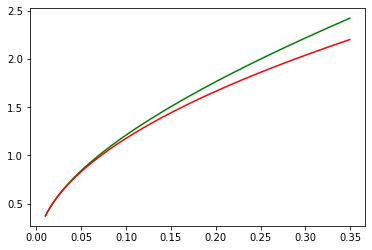

In [241]:
plt.plot(k, correct_w_trips, color = 'green', label = 'Correct Triplets')

plt.plot(k, w_0, color = 'red', label='$\omega_{0}$')

plt.scatter(np.sqrt(kx**2+ky**2), freqs, label= 'triplets')

plt.legend()
plt.grid(True)

In [243]:
kx_0 = np.arange(0.01, 0.35, 0.0005)
ky_0 = np.arange(0.01, 0.35, 0.0005)
# DWL = deep water limit

w_0 = np.sqrt( 9.81 * np.sqrt( (kx_0)**2  + (ky_0)**2 ) )
# DWL formula

In [244]:
w_0.shape

(680,)

In [245]:
DWL_kx = np.arange(0.01, 0.35, 0.0001)
DWL_ky = np.arange(0.01, 0.35, 0.0001)
# DWL = deep water limit

In [246]:
DWL_omega = np.sqrt( 9.81 * np.sqrt( (DWL_kx)**2  + (DWL_ky)**2 ) )
# DWL formula

In [247]:
DWL_omega 

array([0.3724706 , 0.37432832, 0.37617687, ..., 2.20262122, 2.20293613,
       2.20325099])

In [248]:
correct_w_trips

array([0.37302007, 0.38227208, 0.39130985, 0.40014798, 0.40879946,
       0.41727596, 0.42558799, 0.43374504, 0.44175576, 0.44962799,
       0.45736893, 0.46498517, 0.47248278, 0.47986735, 0.48714405,
       0.49431767, 0.50139267, 0.50837317, 0.51526306, 0.52206594,
       0.52878518, 0.53542396, 0.54198525, 0.54847185, 0.5548864 ,
       0.56123138, 0.56750914, 0.5737219 , 0.57987177, 0.58596074,
       0.5919907 , 0.59796344, 0.60388068, 0.60974404, 0.61555508,
       0.62131526, 0.627026  , 0.63268865, 0.63830449, 0.64387477,
       0.64940065, 0.65488327, 0.66032371, 0.66572302, 0.67108219,
       0.67640218, 0.68168392, 0.68692829, 0.69213616, 0.69730833,
       0.70244561, 0.70754876, 0.71261851, 0.71765558, 0.72266066,
       0.72763441, 0.73257748, 0.73749047, 0.742374  , 0.74722864,
       0.75205496, 0.7568535 , 0.76162479, 0.76636934, 0.77108764,
       0.77578019, 0.78044744, 0.78508985, 0.78970785, 0.79430189,
       0.79887237, 0.80341969, 0.80794425, 0.81244644, 0.81692

In [249]:
# add noise 
noise_level = 0.1
noisy_w = correct_w_trips + np.random.uniform(-noise_level, noise_level, len(correct_w_trips))

In [250]:
noisy_w

array([0.35650227, 0.32669364, 0.31528293, 0.36767101, 0.4973814 ,
       0.38191655, 0.42934611, 0.47434884, 0.41448168, 0.5439844 ,
       0.54985839, 0.41534163, 0.47193249, 0.44004302, 0.44411215,
       0.40169506, 0.52330553, 0.50890898, 0.42555881, 0.47779523,
       0.61043836, 0.48333634, 0.47096422, 0.5463624 , 0.65201649,
       0.50964243, 0.60193625, 0.62604583, 0.52739928, 0.63160401,
       0.56554733, 0.62442461, 0.63058662, 0.61689898, 0.53361303,
       0.68837576, 0.59118201, 0.56999235, 0.54645952, 0.66205335,
       0.68491352, 0.55820083, 0.66274232, 0.61102217, 0.70011674,
       0.61127547, 0.71987147, 0.66427536, 0.77948215, 0.62481252,
       0.67065888, 0.63024346, 0.79755723, 0.79312345, 0.67424899,
       0.75963122, 0.79602192, 0.74853063, 0.74830412, 0.6955991 ,
       0.67067551, 0.83629665, 0.8417084 , 0.79298963, 0.7388936 ,
       0.7456221 , 0.82563857, 0.8645119 , 0.86712514, 0.850277  ,
       0.82727869, 0.72024768, 0.74026999, 0.89215727, 0.83821

In [251]:
kx_0.shape

(680,)

Text(0.5, 0, 'k')

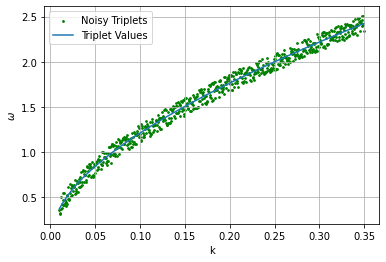

In [252]:
plt.scatter(k, noisy_w , color = 'green', label = 'Noisy Triplets', s = 3)

plt.plot(k, correct_w_trips, label = 'Triplet Values')

plt.grid(True)
plt.legend()
plt.ylabel("$\omega$")
plt.xlabel("k")

## Try method on this data to find U from Noisy Triplets 

Text(0.5, 0, 'k')

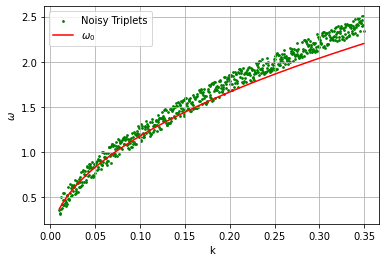

In [253]:
plt.scatter(kx_0, noisy_w , color = 'green', label = 'Noisy Triplets', s = 3)

plt.plot(kx_0, w_0, color = 'red', label='$\omega_{0}$')

plt.grid(True)
plt.legend()
plt.ylabel("$\omega$")
plt.xlabel("k")

In [254]:
noisy_w.shape

(680,)

In [255]:
def obj(U, w_i, w_0, k):
    return w_i - w_0 - k*U

# Initial guess for U
initial_U = np.zeros(len(k))

# Perform the least squares fit using least_squares
result = least_squares(obj, initial_U, args=( noisy_w, w_0, k))

# Optimized U values
optimized_U = result.x

# Print the optimized U values
print("Optimized U values:", optimized_U)


Optimized U values: [-1.59683378e+00 -5.23572913e+00 -6.85159424e+00 -2.76167029e+00
  7.44669166e+00 -2.76145961e+00  3.58791162e-01  3.07978539e+00
 -1.87367748e+00  6.58416587e+00  6.24512851e+00 -3.12132442e+00
  4.93936310e-02 -2.32752347e+00 -2.44294700e+00 -5.20212747e+00
  1.31020999e+00  1.24010053e-01 -4.62402552e+00 -2.17085452e+00
  4.18426883e+00 -2.43709316e+00 -3.27604580e+00  9.92039022e-03
  4.52515011e+00 -2.18059882e+00  1.61115698e+00  2.34294486e+00
 -2.06790397e+00  1.98348159e+00 -9.35216346e-01  1.16222562e+00
  1.15368550e+00  3.98519535e-01 -2.90439348e+00  2.57102324e+00
 -1.14573274e+00 -2.06352277e+00 -3.02879517e+00  7.56409634e-01
  1.32585030e+00 -3.02593810e+00  2.23875815e-01 -1.58881178e+00
  1.05690853e+00 -1.85247582e+00  1.31045498e+00 -5.21127688e-01
  2.72589104e+00 -1.94263543e+00 -7.47708986e-01 -2.01535014e+00
  2.52344314e+00  2.23340729e+00 -1.14087895e+00  1.02253337e+00
  1.84060638e+00  4.59494432e-01  3.26502843e-01 -1.13092617e+00
 -1.8

In [256]:
v = np.array(optimized_U)
v.shape

(680,)

In [257]:
k.shape

(680,)

Text(0.5, 0, 'k')

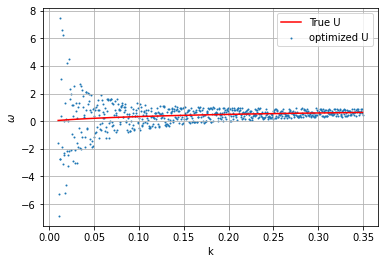

In [258]:
plt.plot(k, Uk[:,0], label = 'True U ', color = 'red')
plt.scatter(k, np.array(optimized_U), s =1, label = "optimized U")

plt.grid(True)
plt.legend()
plt.ylabel("$\omega$")
plt.xlabel("k")

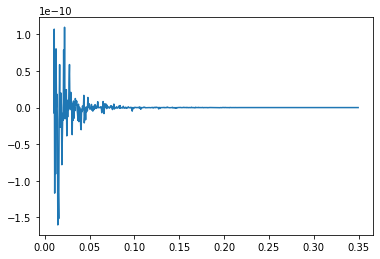

In [259]:
plt.plot(k, noisy_w - w_0 - k*optimized_U)

Text(0.5, 0, 'k')

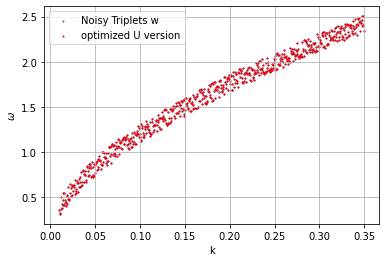

In [260]:
plt.scatter(k, noisy_w, s = 1, label="Noisy Triplets w")
plt.scatter(k, w_0+k*optimized_U, label='optimized U version', color = 'red', s = 1)

plt.grid(True)
plt.legend()
plt.ylabel("$\omega$")
plt.xlabel("k")

In [261]:
k

array([0.01  , 0.0105, 0.011 , 0.0115, 0.012 , 0.0125, 0.013 , 0.0135,
       0.014 , 0.0145, 0.015 , 0.0155, 0.016 , 0.0165, 0.017 , 0.0175,
       0.018 , 0.0185, 0.019 , 0.0195, 0.02  , 0.0205, 0.021 , 0.0215,
       0.022 , 0.0225, 0.023 , 0.0235, 0.024 , 0.0245, 0.025 , 0.0255,
       0.026 , 0.0265, 0.027 , 0.0275, 0.028 , 0.0285, 0.029 , 0.0295,
       0.03  , 0.0305, 0.031 , 0.0315, 0.032 , 0.0325, 0.033 , 0.0335,
       0.034 , 0.0345, 0.035 , 0.0355, 0.036 , 0.0365, 0.037 , 0.0375,
       0.038 , 0.0385, 0.039 , 0.0395, 0.04  , 0.0405, 0.041 , 0.0415,
       0.042 , 0.0425, 0.043 , 0.0435, 0.044 , 0.0445, 0.045 , 0.0455,
       0.046 , 0.0465, 0.047 , 0.0475, 0.048 , 0.0485, 0.049 , 0.0495,
       0.05  , 0.0505, 0.051 , 0.0515, 0.052 , 0.0525, 0.053 , 0.0535,
       0.054 , 0.0545, 0.055 , 0.0555, 0.056 , 0.0565, 0.057 , 0.0575,
       0.058 , 0.0585, 0.059 , 0.0595, 0.06  , 0.0605, 0.061 , 0.0615,
       0.062 , 0.0625, 0.063 , 0.0635, 0.064 , 0.0645, 0.065 , 0.0655,
      

Text(0.5, 0, 'k')

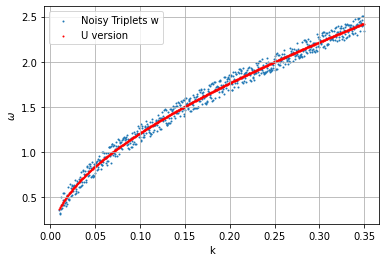

In [262]:
#plt.scatter(k, correct_w_trips, s = 1, label="correct Triplets w")
plt.scatter(k, noisy_w, s = 1, label="Noisy Triplets w")
plt.scatter(k, w_0+k*Uk[:,0], label='U version', color = 'red', s = 1)

plt.grid(True)
plt.legend()
plt.ylabel("$\omega$")
plt.xlabel("k")

In [303]:
noisy_w

array([0.35650227, 0.32669364, 0.31528293, 0.36767101, 0.4973814 ,
       0.38191655, 0.42934611, 0.47434884, 0.41448168, 0.5439844 ,
       0.54985839, 0.41534163, 0.47193249, 0.44004302, 0.44411215,
       0.40169506, 0.52330553, 0.50890898, 0.42555881, 0.47779523,
       0.61043836, 0.48333634, 0.47096422, 0.5463624 , 0.65201649,
       0.50964243, 0.60193625, 0.62604583, 0.52739928, 0.63160401,
       0.56554733, 0.62442461, 0.63058662, 0.61689898, 0.53361303,
       0.68837576, 0.59118201, 0.56999235, 0.54645952, 0.66205335,
       0.68491352, 0.55820083, 0.66274232, 0.61102217, 0.70011674,
       0.61127547, 0.71987147, 0.66427536, 0.77948215, 0.62481252,
       0.67065888, 0.63024346, 0.79755723, 0.79312345, 0.67424899,
       0.75963122, 0.79602192, 0.74853063, 0.74830412, 0.6955991 ,
       0.67067551, 0.83629665, 0.8417084 , 0.79298963, 0.7388936 ,
       0.7456221 , 0.82563857, 0.8645119 , 0.86712514, 0.850277  ,
       0.82727869, 0.72024768, 0.74026999, 0.89215727, 0.83821

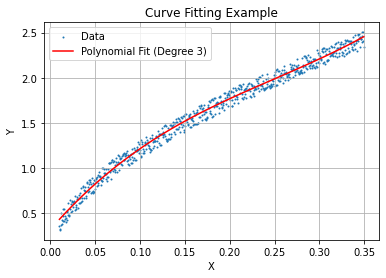

In [263]:
import numpy as np
import matplotlib.pyplot as plt

# Choose the degree of the polynomial (adjust as needed)
degree = 3

# Fit the polynomial
coefficients = np.polyfit(k, noisy_w, degree)

# Create a polynomial function from the coefficients
poly_func = np.poly1d(coefficients)

# Generate x values for the fitted curve
x_fit = np.linspace(min(k), max(k), 680)

# Compute corresponding y values using the polynomial function
y_fit = poly_func(x_fit)

# Plot the original data and the fitted curve
plt.scatter(k, noisy_w, label='Data', s = 1)
plt.plot(x_fit, y_fit, label=f'Polynomial Fit (Degree {degree})', color='red')
plt.legend()
plt.grid(True)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Curve Fitting Example')
plt.show()


In [291]:
y_fit

array([0.43251723, 0.43793321, 0.44333559, 0.44872437, 0.4540996 ,
       0.4594613 , 0.4648095 , 0.47014423, 0.47546551, 0.48077338,
       0.48606787, 0.49134899, 0.49661679, 0.50187128, 0.50711251,
       0.51234049, 0.51755525, 0.52275683, 0.52794525, 0.53312054,
       0.53828272, 0.54343184, 0.54856791, 0.55369096, 0.55880103,
       0.56389813, 0.56898231, 0.57405358, 0.57911198, 0.58415754,
       0.58919027, 0.59421022, 0.59921741, 0.60421187, 0.60919362,
       0.6141627 , 0.61911914, 0.62406295, 0.62899418, 0.63391285,
       0.63881898, 0.64371261, 0.64859377, 0.65346248, 0.65831877,
       0.66316267, 0.66799421, 0.67281342, 0.67762032, 0.68241494,
       0.68719732, 0.69196748, 0.69672545, 0.70147126, 0.70620493,
       0.7109265 , 0.71563599, 0.72033344, 0.72501886, 0.72969229,
       0.73435376, 0.7390033 , 0.74364093, 0.74826668, 0.75288058,
       0.75748267, 0.76207296, 0.76665148, 0.77121828, 0.77577336,
       0.78031677, 0.78484853, 0.78936866, 0.79387721, 0.79837

In [319]:
def obj(U, w_i, w_0, k):
    return w_i - w_0 - k*U

# Initial guess for U
initial_U = np.zeros(len(k))

# Perform the least squares fit using least_squares
result = least_squares(obj, initial_U, args=( y_fit, w_0, k))

# Optimized U values
optimized_U = result.x

# Print the optimized U values
print("Optimized U values:", optimized_U)

Optimized U values: [1.1713003  1.04163771 0.92842451 0.82916172 0.74180633 0.6646743
 0.59636708 0.53571514 0.48173422 0.4335911  0.39057654 0.3520838
 0.31759132 0.28664878 0.25886579 0.23390255 0.21146226 0.19128474
 0.17314121 0.15682986 0.14217217 0.12900977 0.11720183 0.10662278
 0.09716041 0.08871422 0.08119401 0.07451865 0.06861506 0.06341725
 0.05886554 0.05490588 0.05148924 0.04857106 0.04611078 0.04407145
 0.04241935 0.04112369 0.04015627 0.03949128 0.03910506 0.03897589
 0.03908379 0.03941042 0.03993886 0.04065354 0.0415401  0.04258527
 0.04377679 0.04510334 0.04655443 0.04812037 0.04979215 0.05156145
 0.05342052 0.05536218 0.05737978 0.05946709 0.06161838 0.06382827
 0.06609178 0.06840426 0.07076139 0.07315914 0.07559374 0.0780617
 0.08055974 0.08308483 0.0856341  0.08820492 0.0907948  0.09340142
 0.09602262 0.09865638 0.10130083 0.10395418 0.10661481 0.10928116
 0.11195181 0.11462541 0.11730071 0.11997653 0.12265178 0.12532545
 0.12799658 0.13066428 0.13332772 0.13598612 

Text(0.5, 0, 'k')

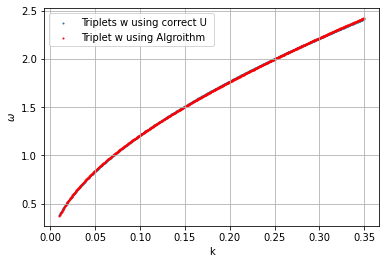

In [320]:
#plt.scatter(k, correct_w_trips, s = 1, label="correct Triplets w")
plt.scatter(k, w_0+k*optimized_U, s = 1, label="Triplets w using correct U ")
plt.scatter(k, w_0+k*Uk[:,0], label='Triplet w using Algroithm', color = 'red', s = 1)

plt.grid(True)
plt.legend()
plt.ylabel("$\omega$")
plt.xlabel("k")

In [321]:
w_0[0]+k[0]*optimized_U[0]

0.3841836065262387

In [322]:
w_0[0]+k[0]*Uk[:,0][0]

0.3730200650354485

Text(0.5, 0, 'k')

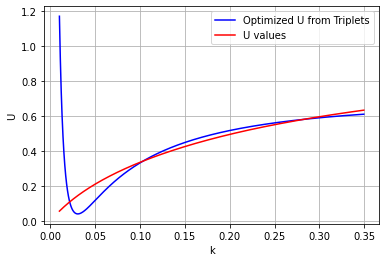

In [323]:
plt.plot(k, optimized_U, label='Optimized U from Triplets', color='blue')
plt.plot(k, Uk[:,0], label = 'U values', color='red')

plt.grid(True)
plt.legend()
plt.ylabel("U")
plt.xlabel("k")

#plt.xlim(0.1, 0.35)
#plt.ylim(0,1)

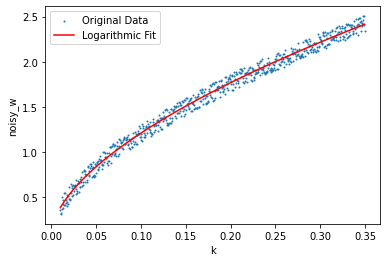

In [326]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the logarithmic function
def log_function(x, a, b, c):
    return a * x**b + c

# Fit the curve
params, covariance = curve_fit(log_function, k, noisy_w)

# Parameters a, b, and c for the logarithmic function
a, b, c = params

# Generate points for the fitted curve
k_fit = np.linspace(min(k), max(k), 680)
y_fit = log_function(k_fit, a, b, c)

# Plot the original data and the fitted curve
plt.scatter(k, noisy_w, label='Original Data', s=1)
plt.plot(k_fit, y_fit, label='Logarithmic Fit', color='red')
plt.xlabel('k')
plt.ylabel('noisy_w')
plt.legend()
plt.show()


In [327]:
y_fit

array([0.38418361, 0.39260599, 0.40086313, 0.40896558, 0.41692278,
       0.42474322, 0.4324346 , 0.44000389, 0.44745744, 0.45480107,
       0.46204011, 0.46917946, 0.47622365, 0.48317686, 0.49004297,
       0.49682559, 0.50352807, 0.51015356, 0.51670498, 0.52318507,
       0.52959642, 0.53594145, 0.54222242, 0.5484415 , 0.55460071,
       0.56070198, 0.5667471 , 0.57273781, 0.57867574, 0.58456243,
       0.59039937, 0.59618796, 0.60192952, 0.60762535, 0.61327665,
       0.61888458, 0.62445027, 0.62997478, 0.63545911, 0.64090426,
       0.64631116, 0.65168071, 0.65701377, 0.66231117, 0.66757371,
       0.67280217, 0.67799728, 0.68315975, 0.68829027, 0.69338951,
       0.6984581 , 0.70349666, 0.7085058 , 0.71348608, 0.71843807,
       0.7233623 , 0.72825931, 0.73312958, 0.73797362, 0.7427919 ,
       0.74758488, 0.752353  , 0.75709671, 0.76181641, 0.76651252,
       0.77118544, 0.77583555, 0.78046323, 0.78506883, 0.78965272,
       0.79421523, 0.79875672, 0.80327749, 0.80777787, 0.81225

In [332]:
def obj(U, w_i, w_0, k):
    return w_i - w_0 - k*U

# Initial guess for U
initial_U = np.zeros(len(k))

# Perform the least squares fit using least_squares
result = least_squares(obj, initial_U, args=( y_fit, w_0, k))

# Optimized U values
optimized_U = result.x

# Print the optimized U values
print("Optimized U values:", optimized_U)

Optimized U values: [1.1713003  1.04163771 0.92842451 0.82916172 0.74180633 0.6646743
 0.59636708 0.53571514 0.48173422 0.4335911  0.39057654 0.3520838
 0.31759132 0.28664878 0.25886579 0.23390255 0.21146226 0.19128474
 0.17314121 0.15682986 0.14217217 0.12900977 0.11720183 0.10662278
 0.09716041 0.08871422 0.08119401 0.07451865 0.06861506 0.06341725
 0.05886554 0.05490588 0.05148924 0.04857106 0.04611078 0.04407145
 0.04241935 0.04112369 0.04015627 0.03949128 0.03910506 0.03897589
 0.03908379 0.03941042 0.03993886 0.04065354 0.0415401  0.04258527
 0.04377679 0.04510334 0.04655443 0.04812037 0.04979215 0.05156145
 0.05342052 0.05536218 0.05737978 0.05946709 0.06161838 0.06382827
 0.06609178 0.06840426 0.07076139 0.07315914 0.07559374 0.0780617
 0.08055974 0.08308483 0.0856341  0.08820492 0.0907948  0.09340142
 0.09602262 0.09865638 0.10130083 0.10395418 0.10661481 0.10928116
 0.11195181 0.11462541 0.11730071 0.11997653 0.12265178 0.12532545
 0.12799658 0.13066428 0.13332772 0.13598612 

Text(0.5, 0, 'k')

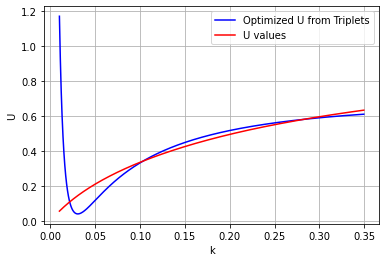

In [333]:
plt.plot(k, optimized_U, label='Optimized U from Triplets', color='blue')
plt.plot(k, Uk[:,0], label = 'U values', color='red')

plt.grid(True)
plt.legend()
plt.ylabel("U")
plt.xlabel("k")

#plt.xlim(0.1, 0.35)
#plt.ylim(0,1)